# Constructing a flow network

This Notebook processes the particle tracking simulation output and then uses the valid particle trajectories to create a flow network.

In [1]:
import pickle
import sys
from pathlib import Path

import networkx as nx
import numpy as np

sys.path.insert(1, str(Path.cwd() / 'utils'))
from hexbin import Hexbin  # noqa: E402
from particle import Particle  # noqa: E402
from particletype import *  # noqa: E402
from plot import plot_particles, plot_hexbins  # noqa: E402
from season import Season  # noqa: E402
from zone import Zone  # noqa: E402

In [2]:
particle_type = Restricted
season = Season.fall

## Post-processing the simulation

The simulated particle dispersal is stored in a NetCDF file that can be read to obtain positional and local environmental information for each particle at each recorded time. We are interested in the initial and final positions of particles, the definition of which changes depending on how the biology of the modelled particles is imposed.


In [3]:
# Read simulation sampled variables
sim = particle_type.get_simulation(season)
traj_lons = sim.variables['lon'][:]
traj_lats = sim.variables['lat'][:]
traj_mlds = sim.variables['MLD'][:]

# Create list of particles that did not leave the domain
particles = [Particle(lons, lats, mlds) for lons, lats, mlds in zip(traj_lons, traj_lats, traj_mlds)]
print(len(particles))

1892996


In [4]:
# plot_particles(particles, 0)
# plot_particles(particles, -1)

### Filtering initial positions

Species distribution models (SDMs) describe the suitability of habitat for each cell on a rectangular grid covering the domain. Particles originating from different genetic zones (i.e., particles of different genetic lineages) have different suitable habitat distributions. The initial positions of restricted particles must be filtered to reflect that they will only spawn in suitable habitat. This is not of concern for unrestricted particles as their domain has been defined by the field data used in the simulation.


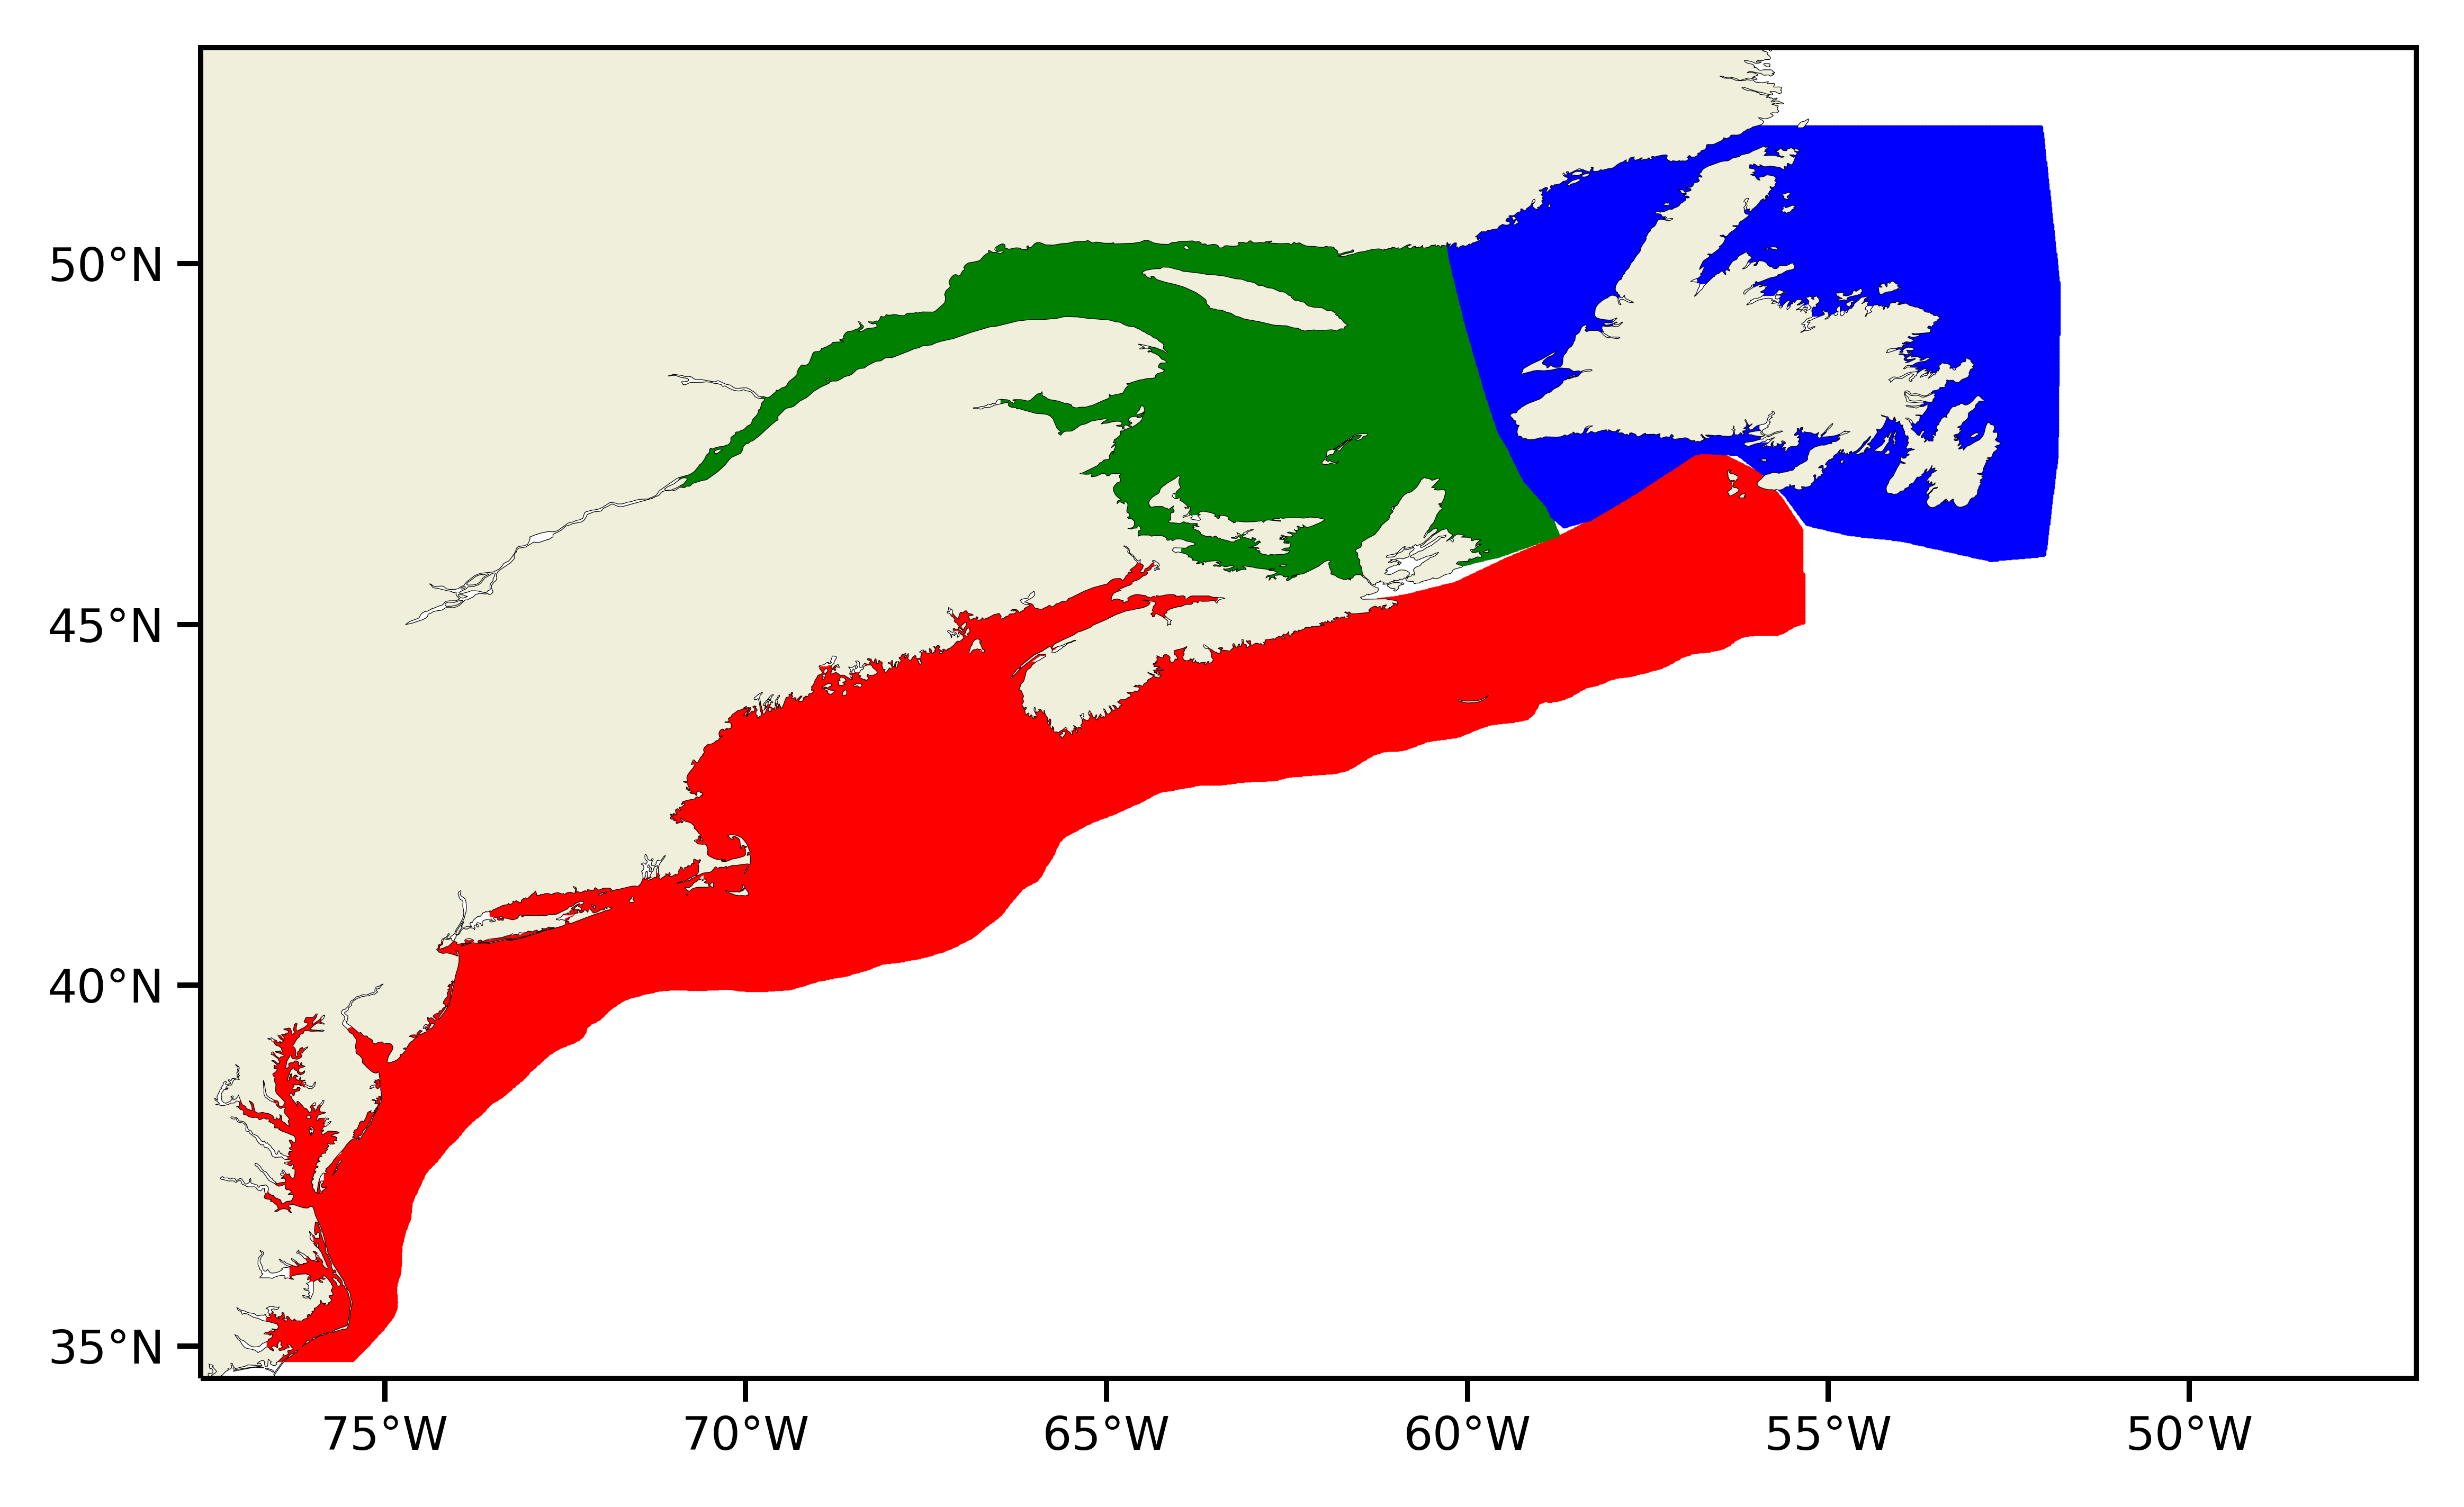

In [5]:
if particle_type.genetics:
    # Load data regarding genetic zones
    with open(Path.cwd() / 'data' / 'zones' / 'zones.pickle', 'rb') as file:
        zones = pickle.load(file)

    # Assign each particle's genetic lineage based on their spawn position
    for particle in particles:
        particle.assign_genetic_lineage(zones)
    
    # Remove particles from an undefined genetic lineage
    particles = [particle for particle in particles if particle.genetic_lineage is not Zone.UNDEFINED]
    
    # Plot genetic lineages
    particle_type.plot(particles, 0, zones)
else:
    zones = None

185480 from 0 settled
46570 from 1 settled
12160 from 2 settled


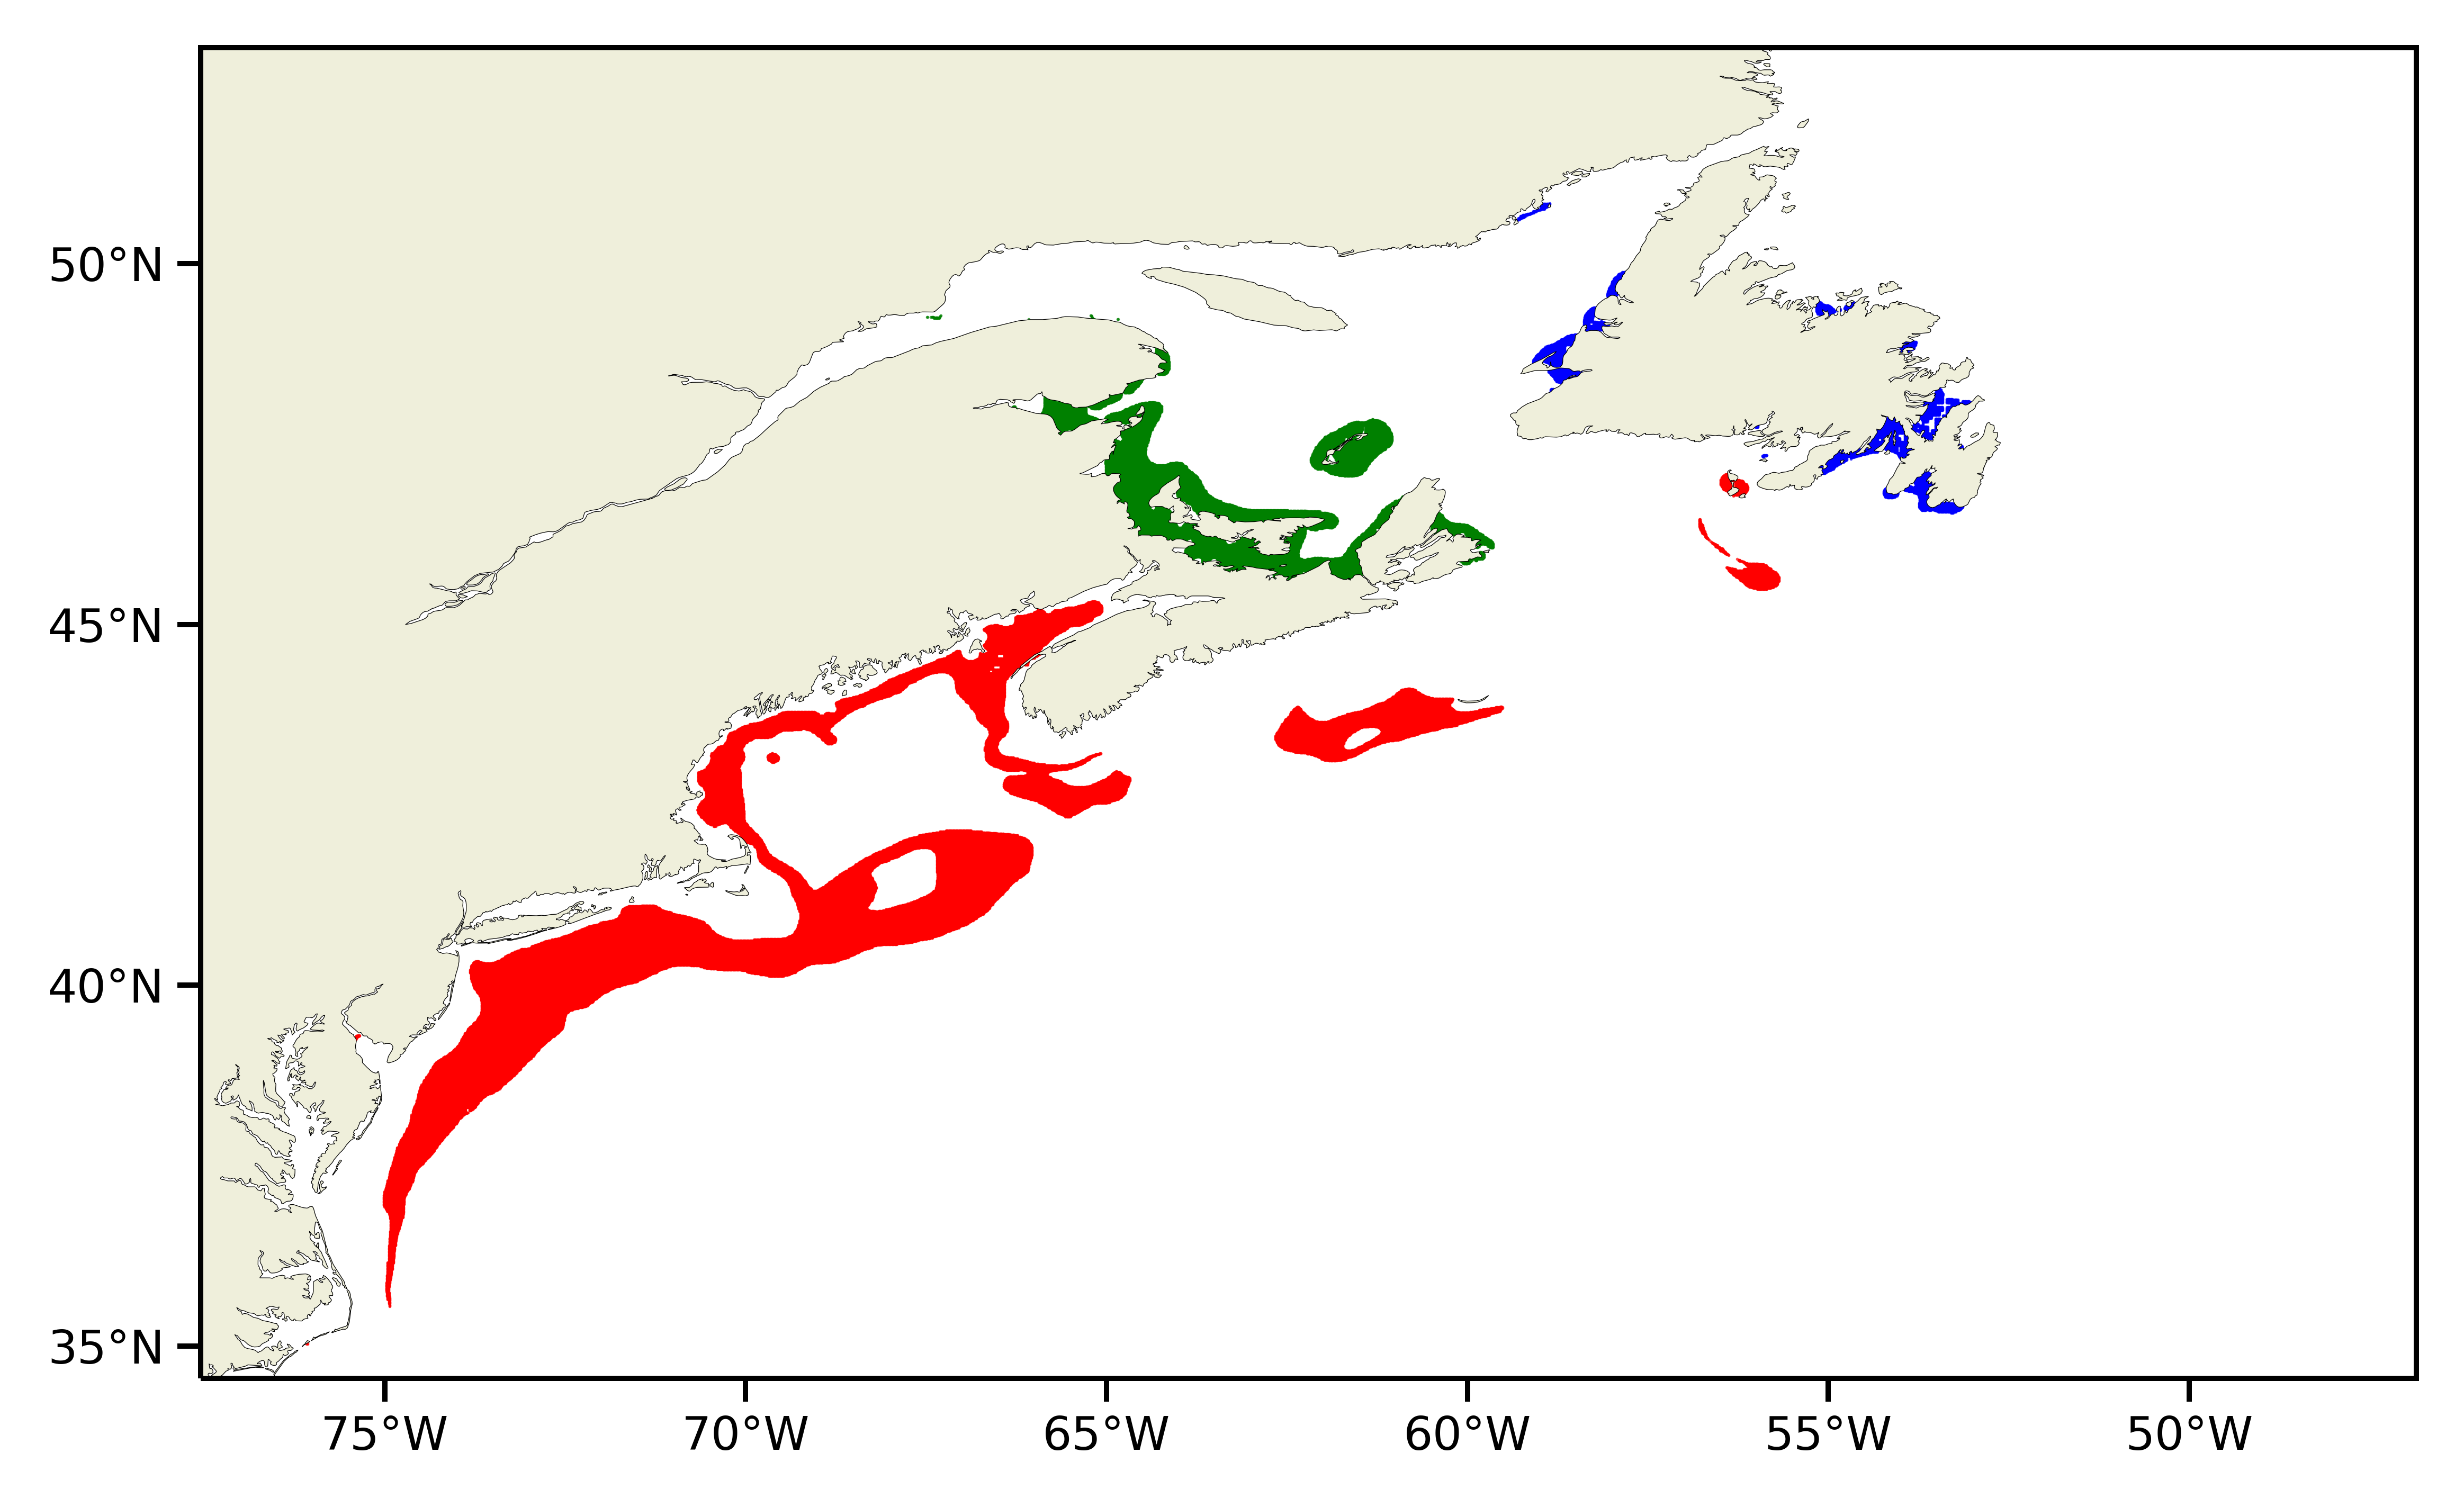

In [6]:
particles = particle_type.filter_initial_positions(particles, zones)
particle_type.plot(particles, 0, zones)

### Filtering final positions

Restricted particles settle during their *competency period* at the first time in which they are in suitable habitat. The final positions of unrestricted particles are merely their positions at their *pelagic larval duration*.


In [7]:
particles = particle_type.filter_final_positions(particles, zones)

106219 from 0 settled
22149 from 1 settled
2366 from 2 settled


### Beaching

There is no mechanism in the simulation to specifically handle particles that are beached or leave the field domain. Particles that become beached can be identified by their sampled MLD or bathymetry, which will be 0 for times on land. Particles that left the field domain have their positions written as a masked element. Any trajectory that encounters either type of indicator can safely be deemed bad and removed from further consideration.

130734
122208


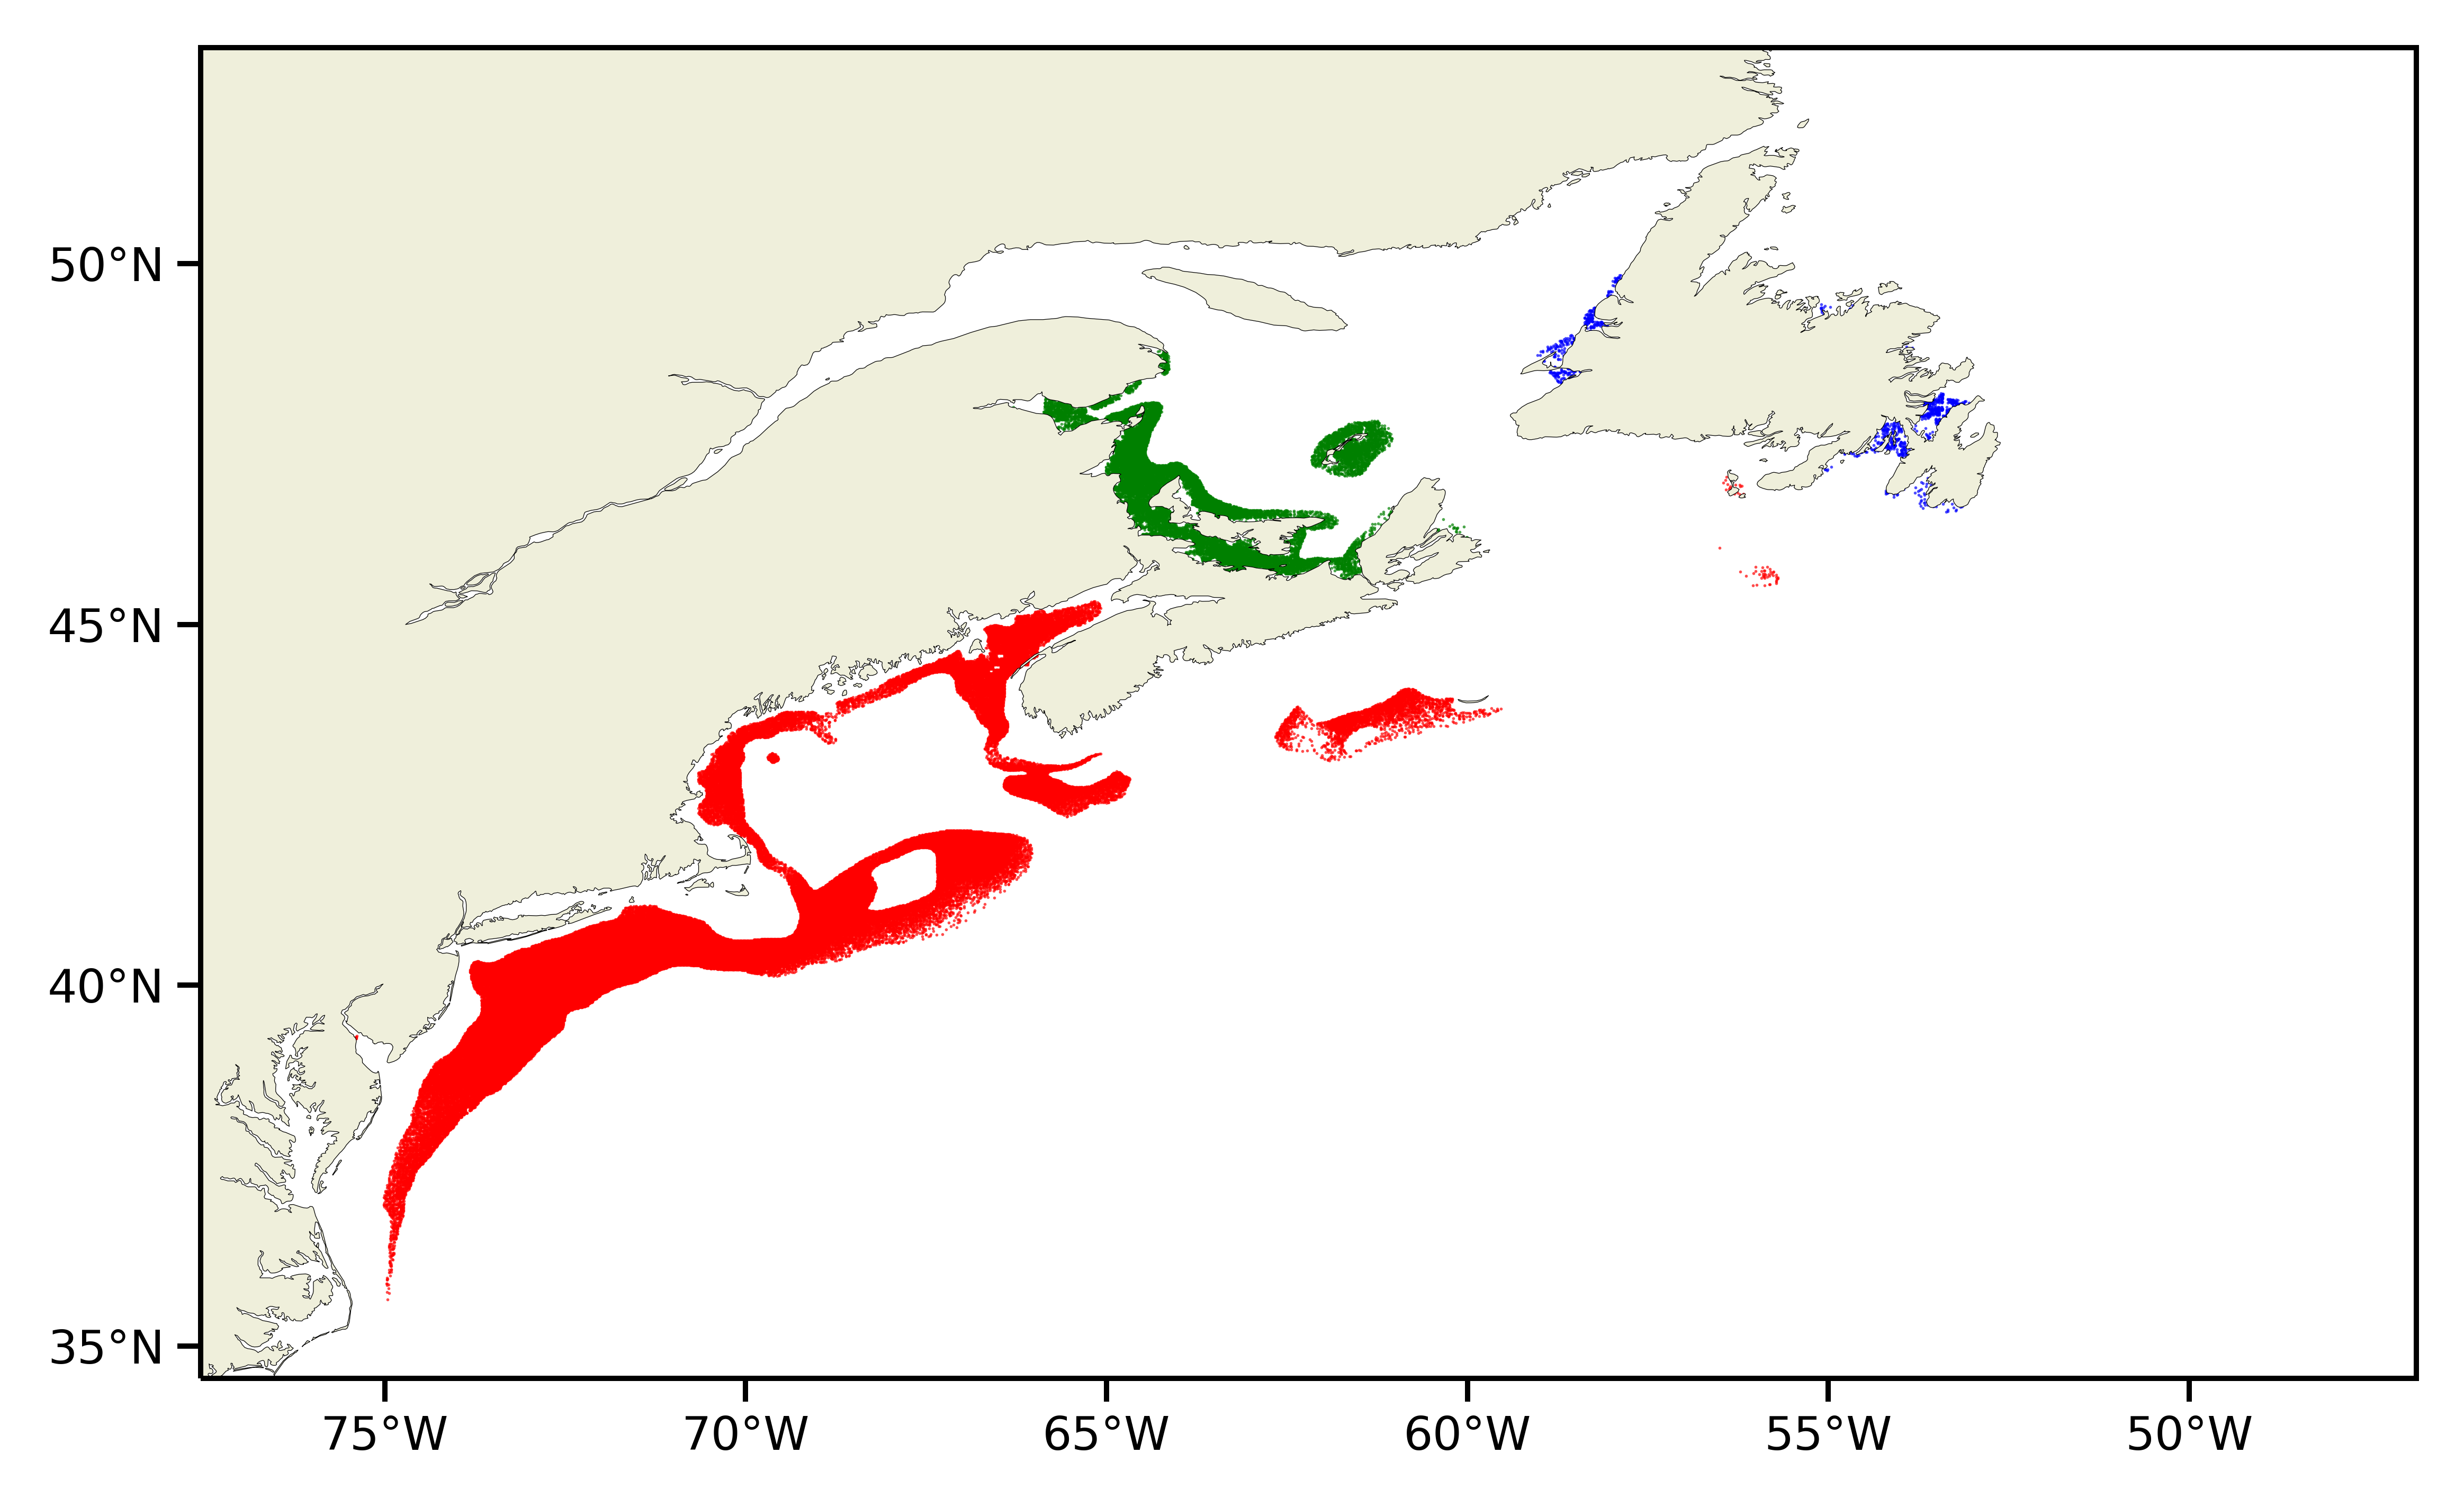

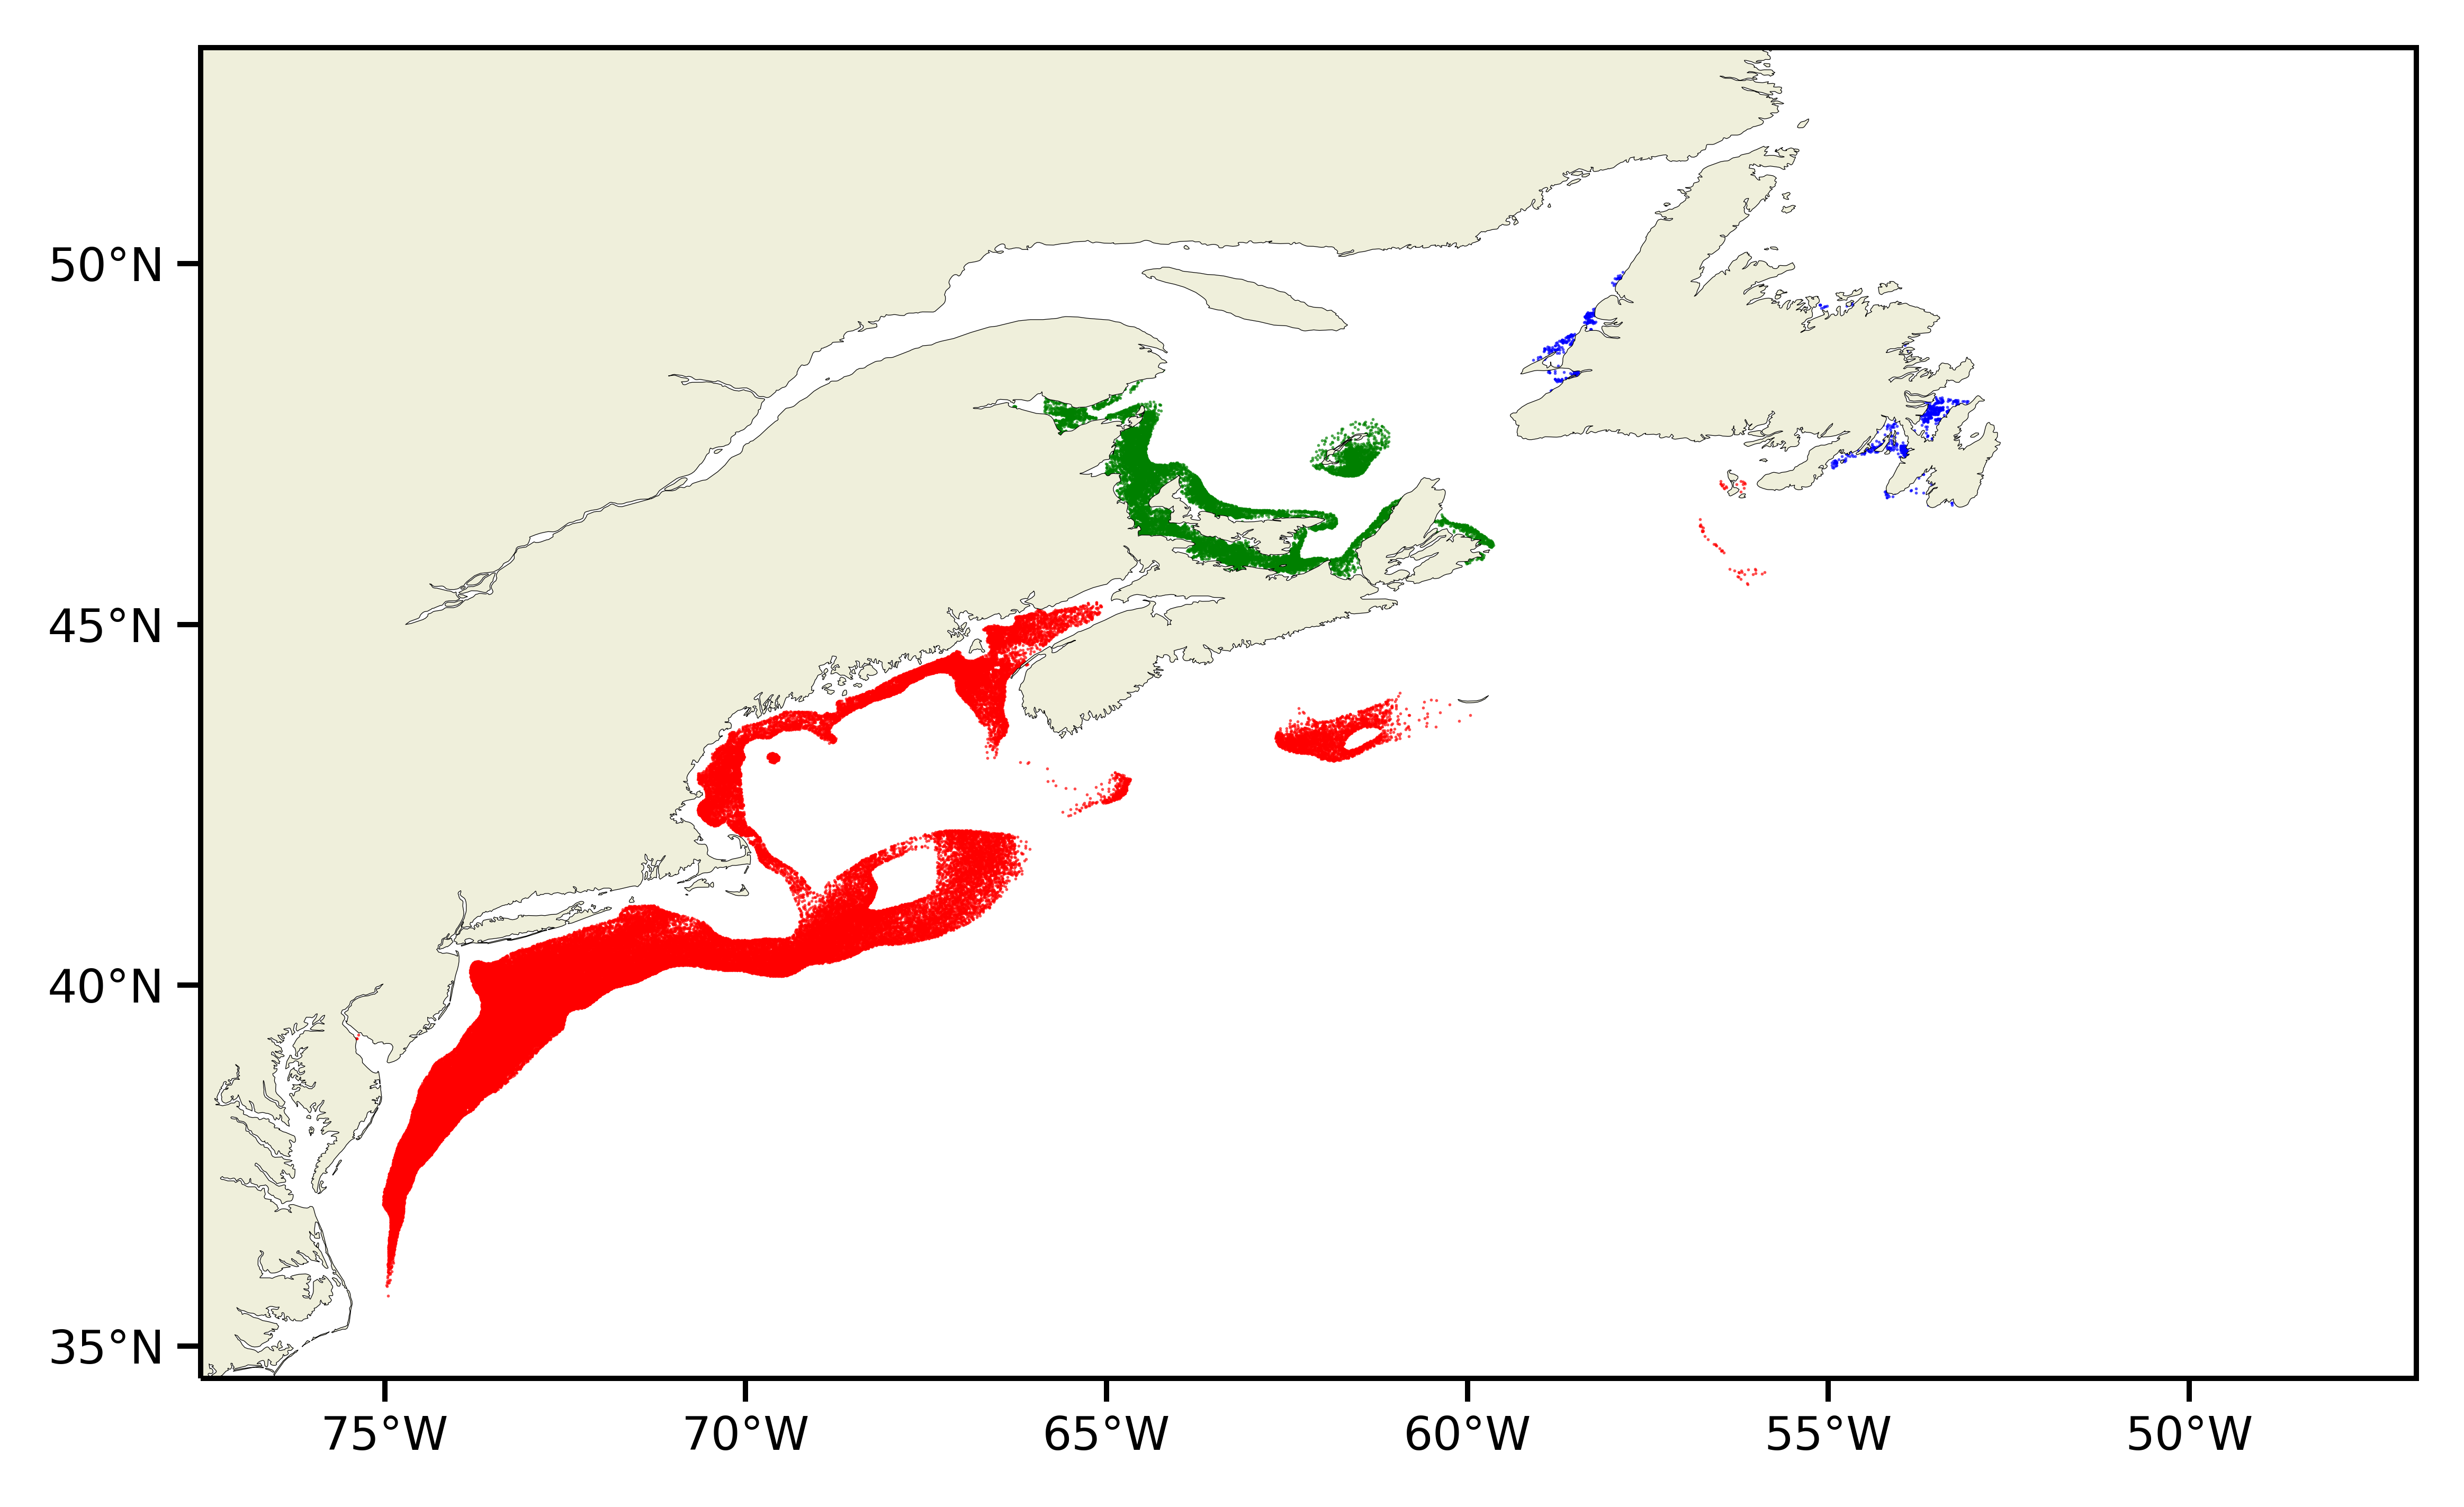

In [8]:
print(len(particles))
particles = [particle for particle in particles if not particle.is_beached()]
print(len(particles))

particle_type.plot(particles, 0, zones, path=Path.cwd() / 'data' / 'SDM' / 'sdm.png')
particle_type.plot(particles, -1, zones)

## Constructing a flow network

With the simulation processed, particle dispersal can be represented discretely.

### Binning particle trajectories

Using Uber's hexagonal hierarchical geospatial indexing system, *H3*, an icosahedral-hexagonal grid of a specified resolution `RESOLUTION` can be created, allowing for a (lat, lon) coordinate to be binned into a hexagonal cell of a known index automatically.

With particles binned into a set of *nodes* $V$, the directional exchange of particles between nodes is represented by a set of unweighted, directed *edges* $E \subseteq \{(i, j)\ |\ (i,j)\in V^2\}$, allowing for loops.

In [9]:
# Bin initial and final particle locations
source_nodes, target_nodes = Hexbin.bin_particles(particles)

# Filter out trajectories whose final position was an uninitialized bin
failed_particles = np.isin(target_nodes, np.setdiff1d(target_nodes, source_nodes))
source_nodes = np.delete(source_nodes, failed_particles)
target_nodes = np.delete(target_nodes, failed_particles)
print(len(source_nodes), len(source_nodes) == len(target_nodes))

# Write edge list describing trajectories: a flow map
edges = np.array([(source, target) for source, target in zip(source_nodes, target_nodes)],
                 dtype=tuple)
with open(Path.cwd() / 'network' / particle_type.name / season.name / 'edges.pickle', 'wb') as file:
    pickle.dump(edges, file, protocol=pickle.HIGHEST_PROTOCOL)

121867 True


### Representing as a graph

With a list of edges and nodes obtained (duplicate edges are temporarily possible due to identical trajectories of multiple particles being possible), a loop-digraph $G = (V, E)$ is represented as a `DiGraph` object from the `networkx` library.

When constructing the graph, an edge $(i, j, w_{i\to j}) \in E$ is weighted by the number of transitions $w_{i\to j}$ that occur from node $i$ to node $j$ such that $E \subseteq \{(i, j, w_{i \to j})\ |\ (i,j)\in V^2\}$. 

In [10]:
G = nx.DiGraph()

for source_node, target_node in edges:
    if G.has_edge(source_node, target_node):
        # Record a transition along an existing edge
        G[source_node][target_node]['weight'] += 1
    else:
        # Create a new edge for transition
        G.add_edge(source_node, target_node, weight=1)

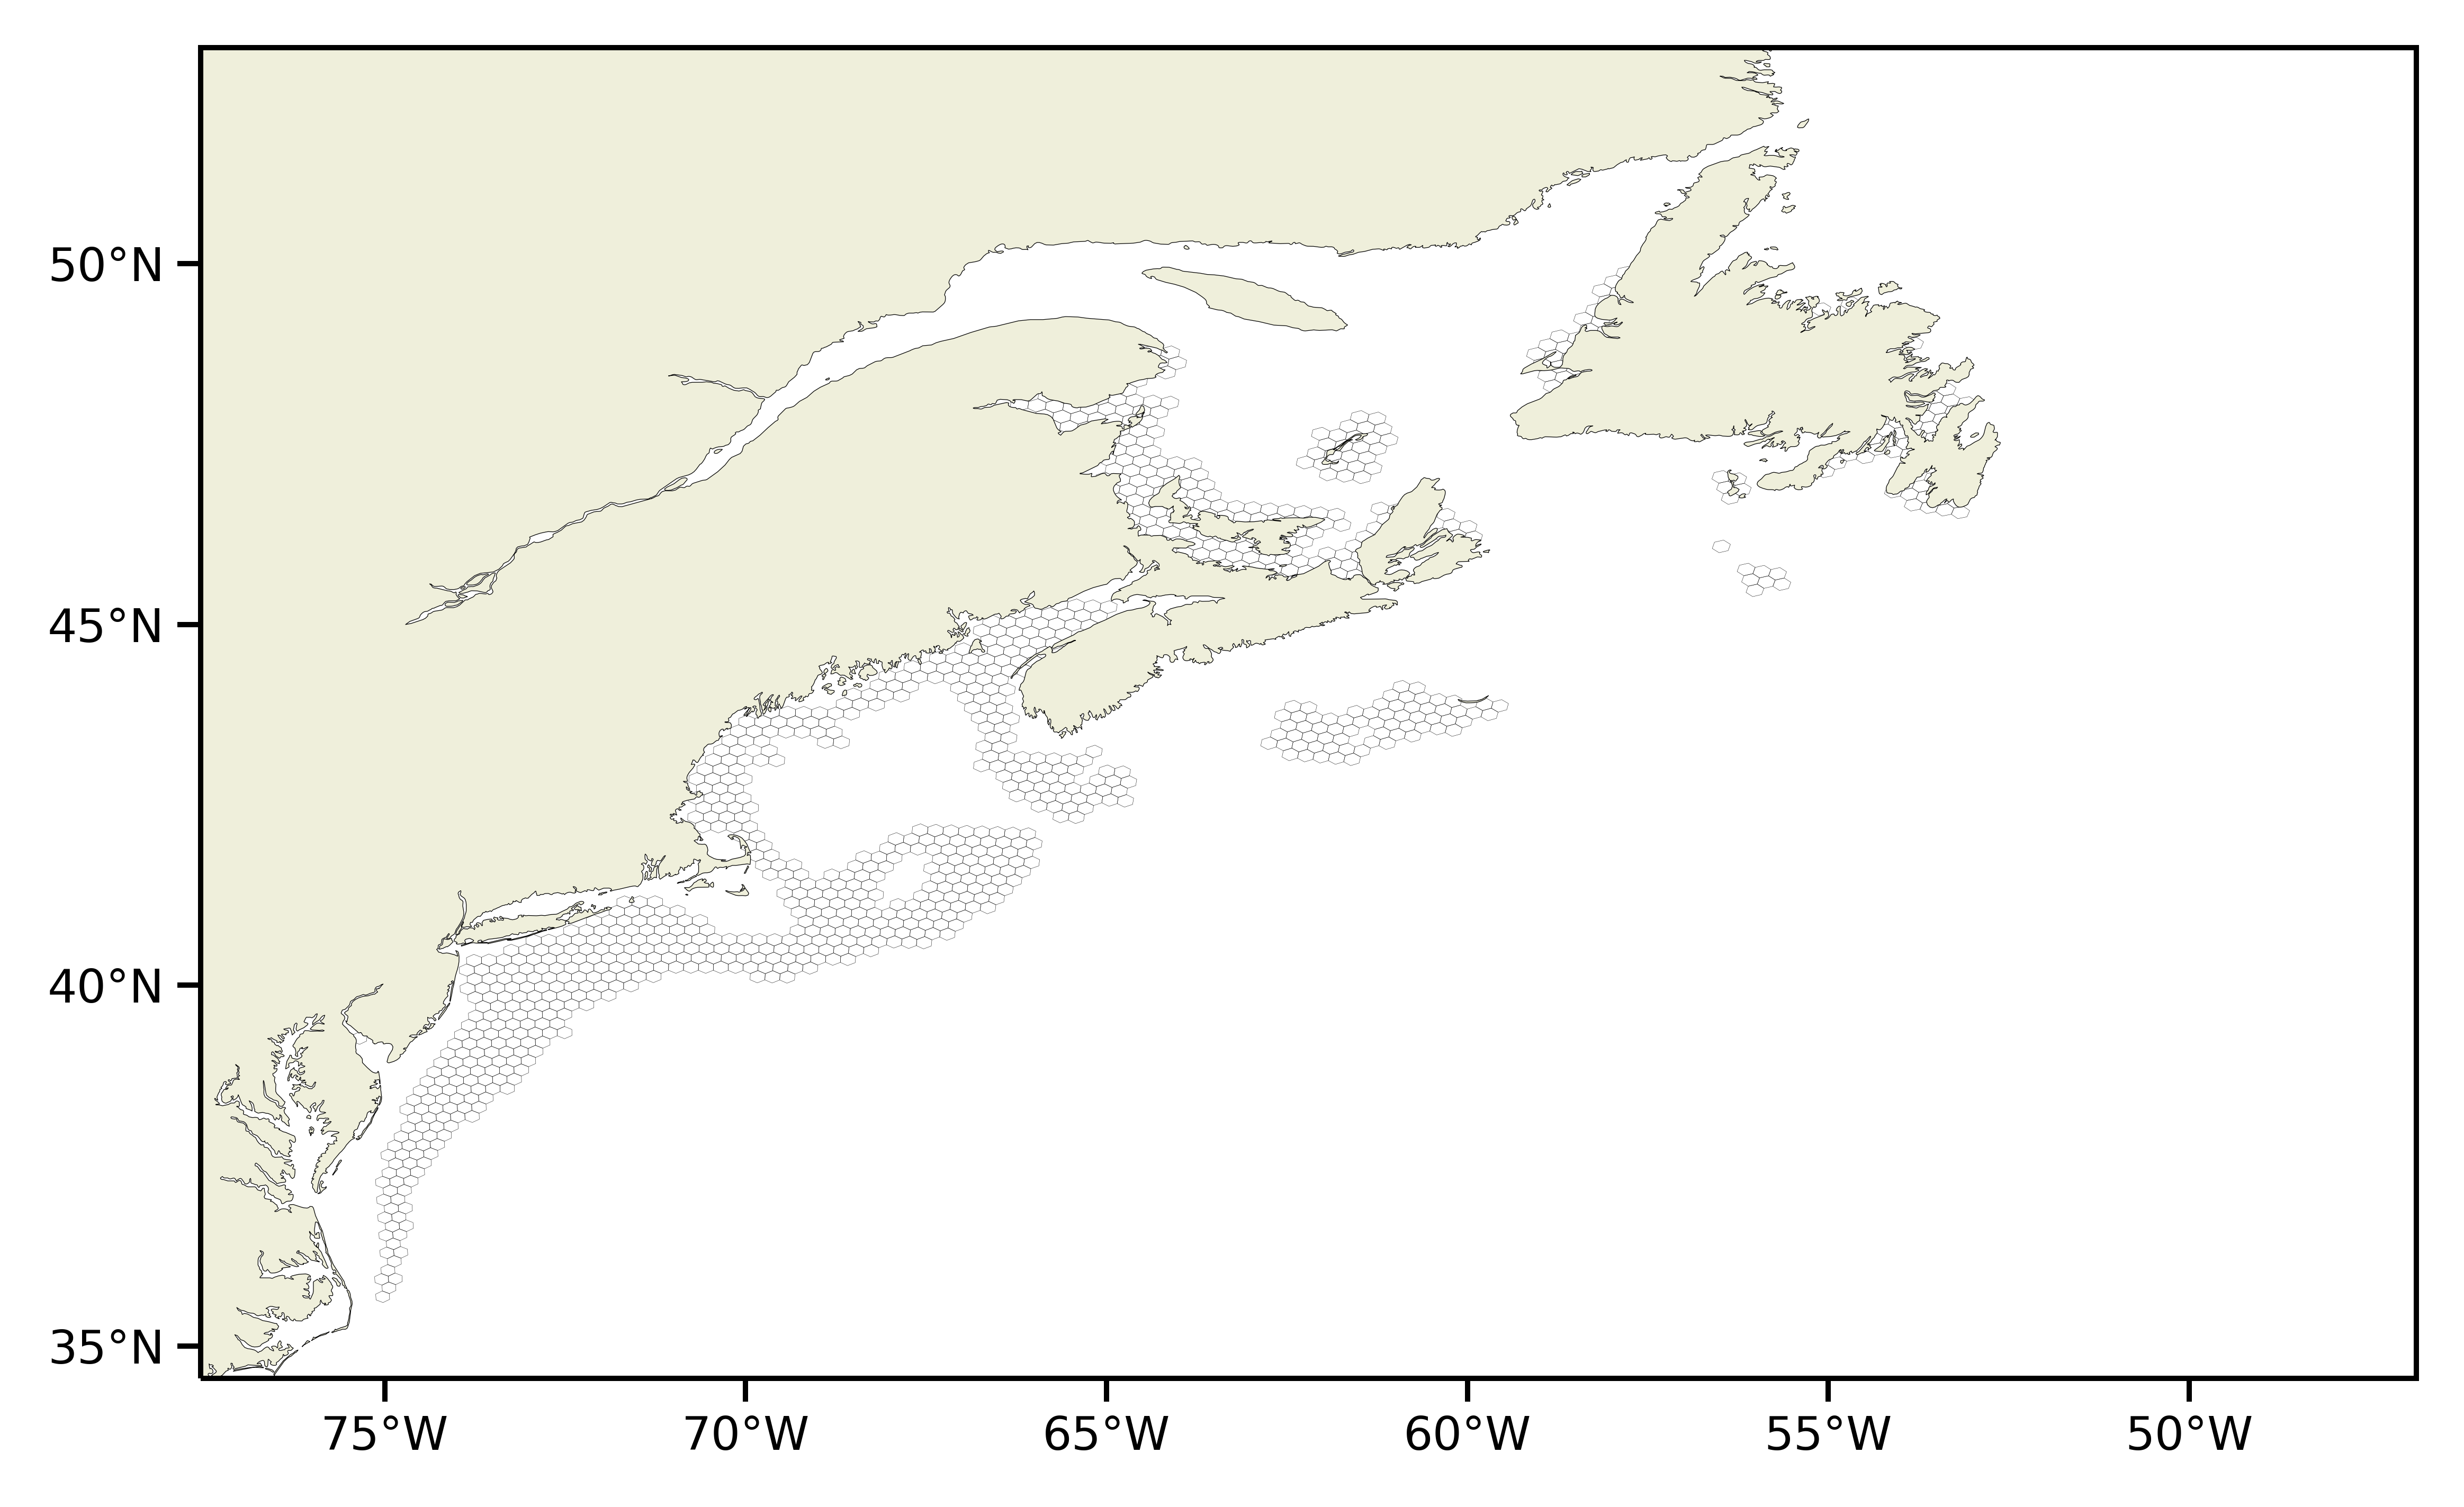

In [11]:
# Plot bins
hexbins = [Hexbin(node) for node in G.nodes]
plot_hexbins(hexbins)

### Normalizing edge weights

Edge weights should be normalized such that an edge $(i, j, p_{i\to j}) \in E$ has a weight corresponding to the probability for a particle to transition from node $i$ to node $j$, $p_{i\to j}$.

This transition probability is given by

$$
p_{i\to j} = \frac{w_{i\to j}}{\sum_{k \in V}^{}{w_{i\to k}}}, i, j \in V
$$

as done by Bohlin et al. (2014). This results in a set of edges $E \subseteq \{(i, j, p_{i \to j})\ |\ (i,j)\in V^2\}$

With each edge now being weighted by the probability of transition (and thus having the outgoing probabilities from any source node sum to 1), the network is a Markov chain (since nodes are effectively positional states with no memory and edges are the transition probabilities between states) for which a transition matrix can be formalized.


In [12]:
for source_node, _ in edges:
    W = sum(w for (_, _, w) in G.out_edges(source_node, data='weight'))

    for (_, target_node, _) in G.out_edges(source_node, data='weight'):
        G[source_node][target_node]['weight'] *= 1 / W

In [13]:
# Retrieve all nodes in domain and their integer mapping
with open(Path.cwd() / 'network' / 'label_map.pickle', 'rb') as file:
    label_map = pickle.load(file)

transition_matrix = np.empty((len(label_map.keys()), len(label_map.keys())))

# Populate transition matrix
for source_node in G.nodes:
    for target_node in G.nodes:
        if G.has_edge(source_node, target_node):
            # Transition probability is weight of edge
            p = G[source_node][target_node]['weight']
        else:
            # No connection between nodes
            p = 0
        transition_matrix[label_map[source_node], label_map[target_node]] = p

with open(Path.cwd() / 'network' / particle_type.name / season.name / 'transition_matrix.pickle', 'wb') as file:
    pickle.dump(transition_matrix, file, protocol=pickle.HIGHEST_PROTOCOL)

### Formatting for *Infomap*

The network should be written for use of *Infomap* using the formatting:

`source_node target_node [weight]`

*Infomap* has requirements for the labels given to nodes, so a mapping is applied to relabel nodes as natural numbers. This is used later to relabel the nodes to *H3* indices that have spatial meaning and to retrieve the transition probability from the transition matrix given two *H3* indices.


In [14]:
with open(Path.cwd() / 'network' / particle_type.name / season.name / 'network.txt', 'w') as file:
    file.write('# source target weight\n')
    
    for node in G.nodes:
        for (_, target_node, w) in G.out_edges(node, data='weight'):
            file.write(f'{label_map[node]} {label_map[target_node]} {w}\n')

## References

Bohlin, L., Edler, D., Lancichinetti, A., & Rosvall, M. (2014). Community Detection and Visualization of Networks with the Map Equation Framework. In Y. Ding, R. Rousseau, & D. Wolfram (Eds.), *Measuring Scholarly Impact: Methods and Practice* (pp. 3–34). Springer International Publishing. https://doi.org/10.1007/978-3-319-10377-8_1